# Flat Gaussian with compositional score matching


In this notebook, we will use the compositional score matching to learn the posterior of a flat Gaussian model.
The problem is defined as follows:
- The prior is a Gaussian distribution with mean 0 and standard deviation 0.1.
- The simulator/likelihood is a Gaussian distribution with mean 0 and standard deviation 0.1.
- We have an analytical solution for the posterior.
- We set the dimension of the problem to $D=10$.

In [ ]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics
from torch.utils.data import DataLoader

from diffusion_model import ScoreModel, SDE, train_score_model, sde_sampling, \
    adaptive_sampling, probability_ode_solving, langevin_sampling, euler_maruyama_sampling
from diffusion_model.helper_networks import GaussianFourierProjection, ShallowSet
from problems.gaussian_flat import GaussianProblem, Prior, Simulator, visualize_simulation_output, \
    generate_synthetic_data, \
    sample_posterior, posterior_contraction, kl_divergence

In [ ]:
torch_device = torch.device("cpu")

In [ ]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
prior_test = prior.sample(2)
sim_test = simulator_test(prior_test, n_obs=1000)
visualize_simulation_output(sim_test['observable'])

In [ ]:
batch_size = 128
number_of_obs = 1# [1, 5]  # multiple obs means we amortize over number of conditions

current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching', 'edm-training', 'edm-sampling'][-1]
)

dataset = GaussianProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=True,
    number_of_obs=number_of_obs
)
dataset_valid = GaussianProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

for test in dataloader:
    print(test[0].shape)
    print(test[1].shape)
    print(test[2].shape)
    break

In [ ]:
# Define diffusion model
time_embedding = nn.Sequential(
    GaussianFourierProjection(8),
    nn.Linear(8, 8),
    nn.Mish()
)
summary_dim = 10
#summary_net = ShallowSet(dim_input=10, dim_output=summary_dim, dim_hidden=8) if isinstance(number_of_obs, list) else None

score_model = ScoreModel(
    input_dim_theta=prior.n_params_global,
    input_dim_x=summary_dim,
    #summary_net=summary_net,
    time_embedding=time_embedding,
    hidden_dim=256,
    n_blocks=5,
    max_number_of_obs=max(number_of_obs) if isinstance(number_of_obs, list) else number_of_obs,
    prediction_type=['score', 'e', 'x', 'v', 'F'][4],
    sde=current_sde,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid', 'edm'][-1],
    prior=prior,
    name_prefix='gaussian_edm'
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=1000, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

In [ ]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True,
                                       map_location=torch.device(torch_device)))
score_model.eval();

# Validation

In [ ]:
data_size = 10  # number of observations
obs_n_time_steps = 0
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=100, data_size=data_size,
                                                         normalize=False, random_seed=0)
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 100
score_model.current_number_of_obs = 1
score_model.sde.s_shift_cosine = 0

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
sample_posterior_single = lambda vd: sample_posterior(
    vd,
    prior_sigma=prior.scale,
    sigma=prior.simulator.scale,
    n_samples=n_post_samples
)
posterior_global_samples_true = np.array([sample_posterior_single(vd) for vd in valid_data])

In [ ]:
diagnostics.recovery(posterior_global_samples_true, np.array(valid_prior_global), variable_names=param_names)
diagnostics.calibration_ecdf(posterior_global_samples_true, np.array(valid_prior_global),
                             difference=True, variable_names=param_names);

In [ ]:
mini_batch_size = 10
t1_value = 0.8 #mini_batch_size /( data_size //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor_prior': 1
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

In [ ]:
posterior_global_samples_valid = langevin_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
                                                   n_post_samples=n_post_samples,
                                                   mini_batch_arg=mini_batch_arg,
                                                   diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler{score_model.current_number_of_obs}.png')

In [ ]:
# posterior_global_samples_valid = sde_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
#                                               n_post_samples=n_post_samples, diffusion_steps=300,
#                                               method=['euler', 'milstein_grad_free', 'srk1w1'][1],
#                                            device=torch_device, verbose=True)

posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
                                              n_post_samples=n_post_samples, diffusion_steps=500,
                                              #mini_batch_arg=mini_batch_arg,
                                              device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = sde_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
                                              n_post_samples=n_post_samples, diffusion_steps=1000,
                                              method=['euler', 'milstein_grad_free', 'srk1w1'][1],
                                              mini_batch_arg=mini_batch_arg,
                                              device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

In [ ]:
mini_batch_size = 10
t1_value = 0.01 #mini_batch_size /( data_size //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    #'size': mini_batch_size,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t)
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()

t0_value, t1_value

In [18]:
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
                                                   n_post_samples=n_post_samples,
                                                   #mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


VariableArray(0.3935)

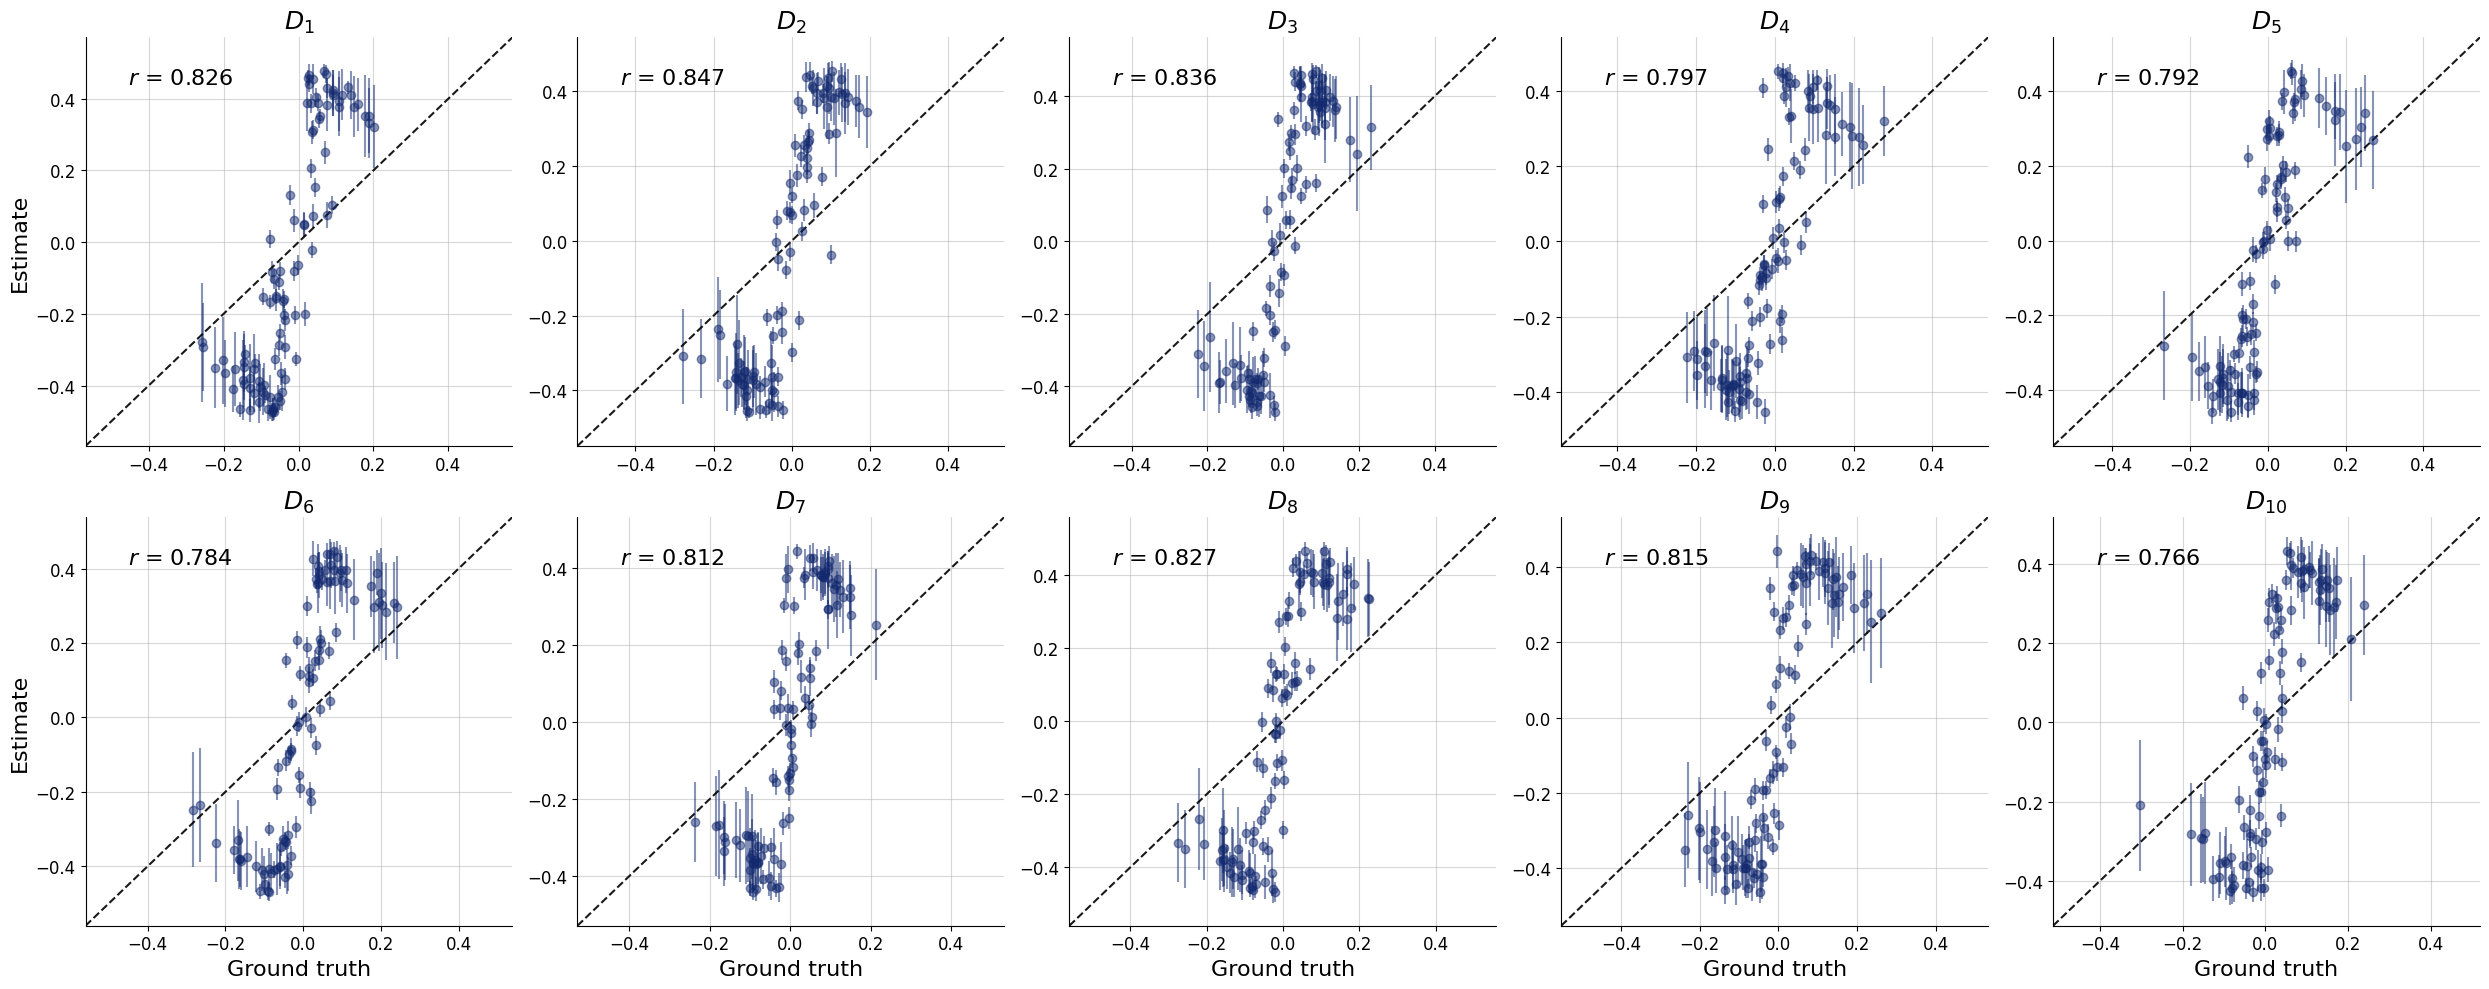

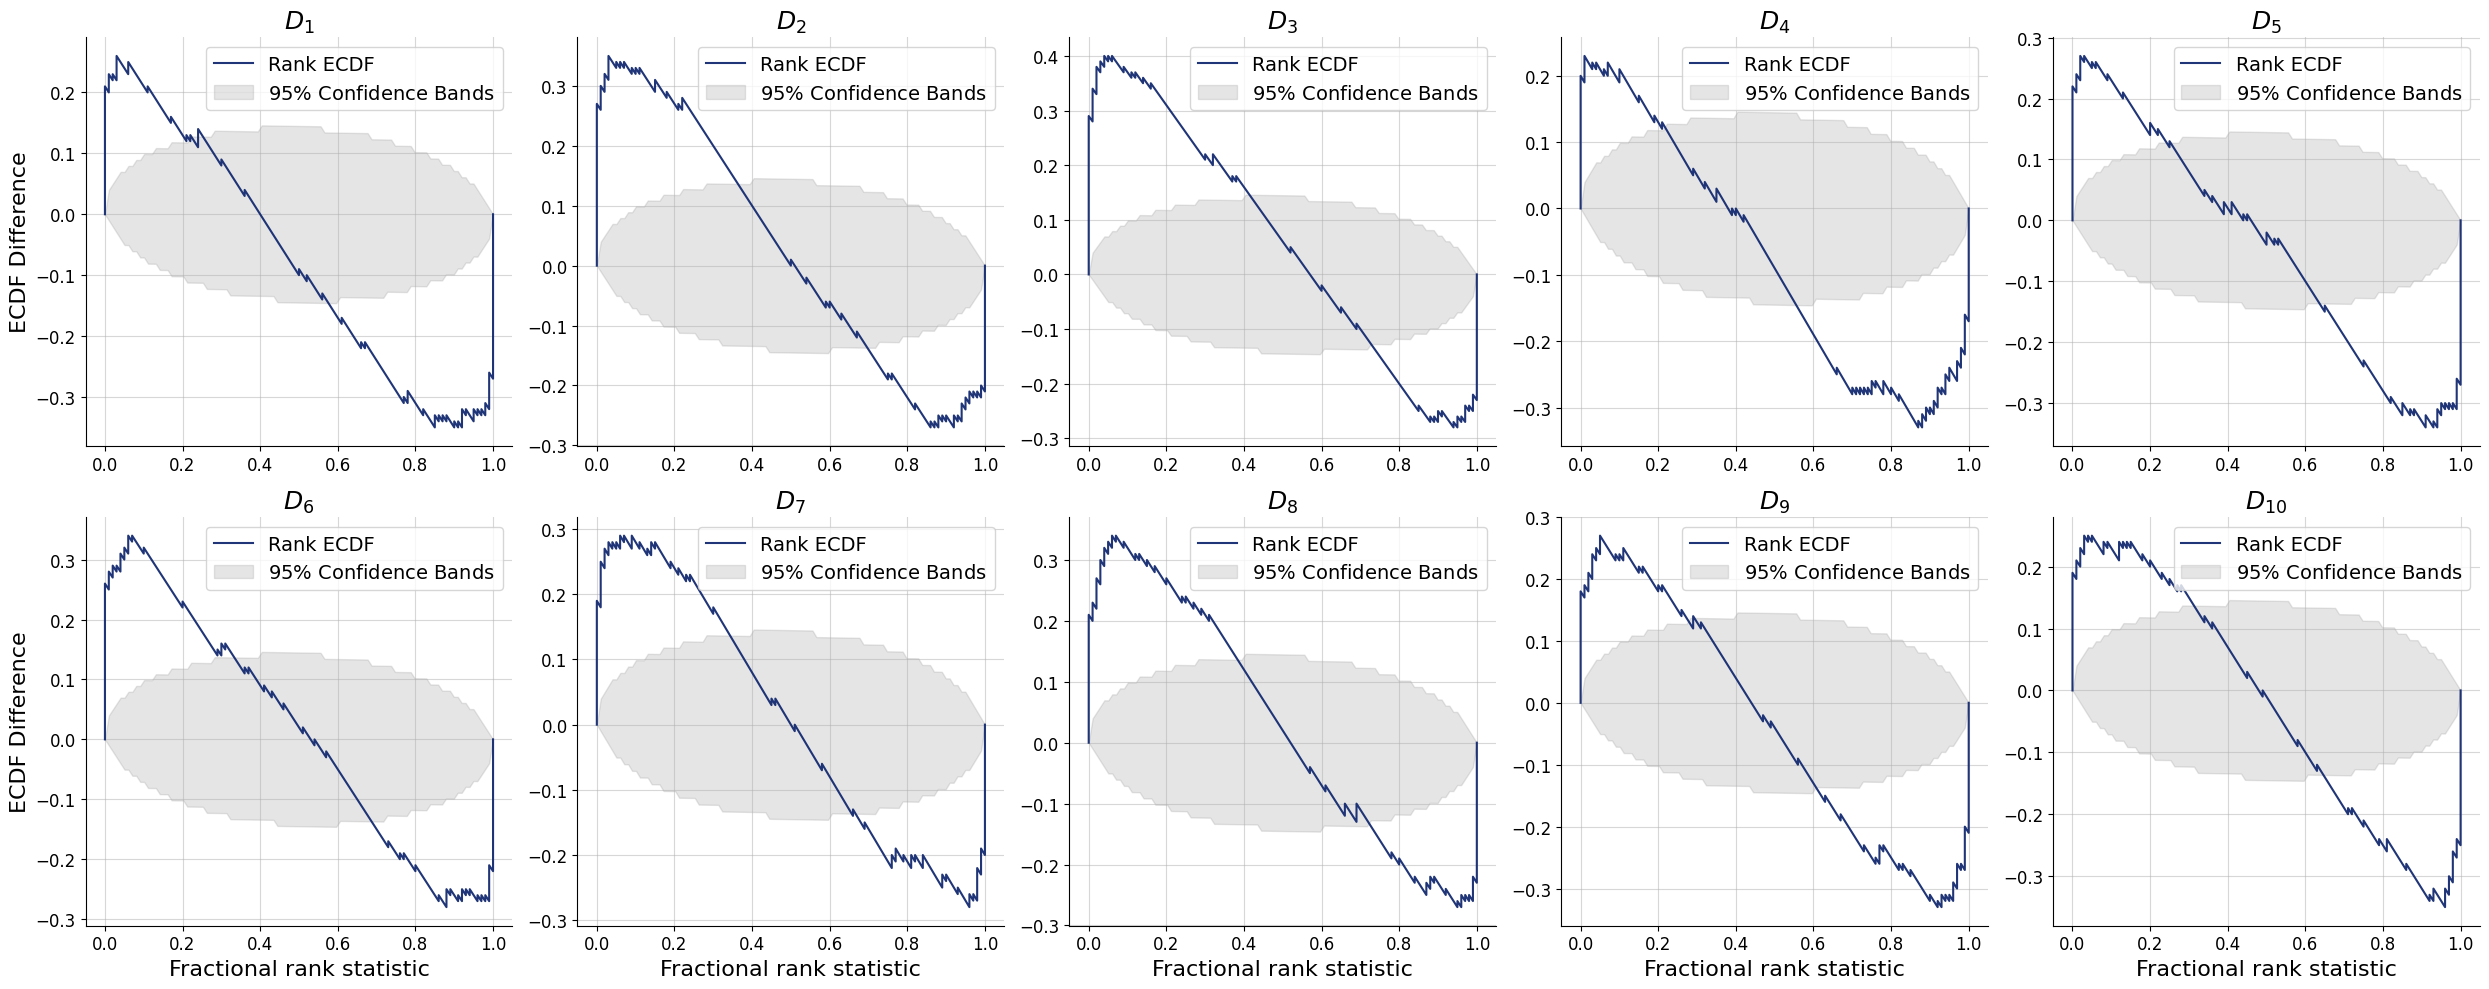

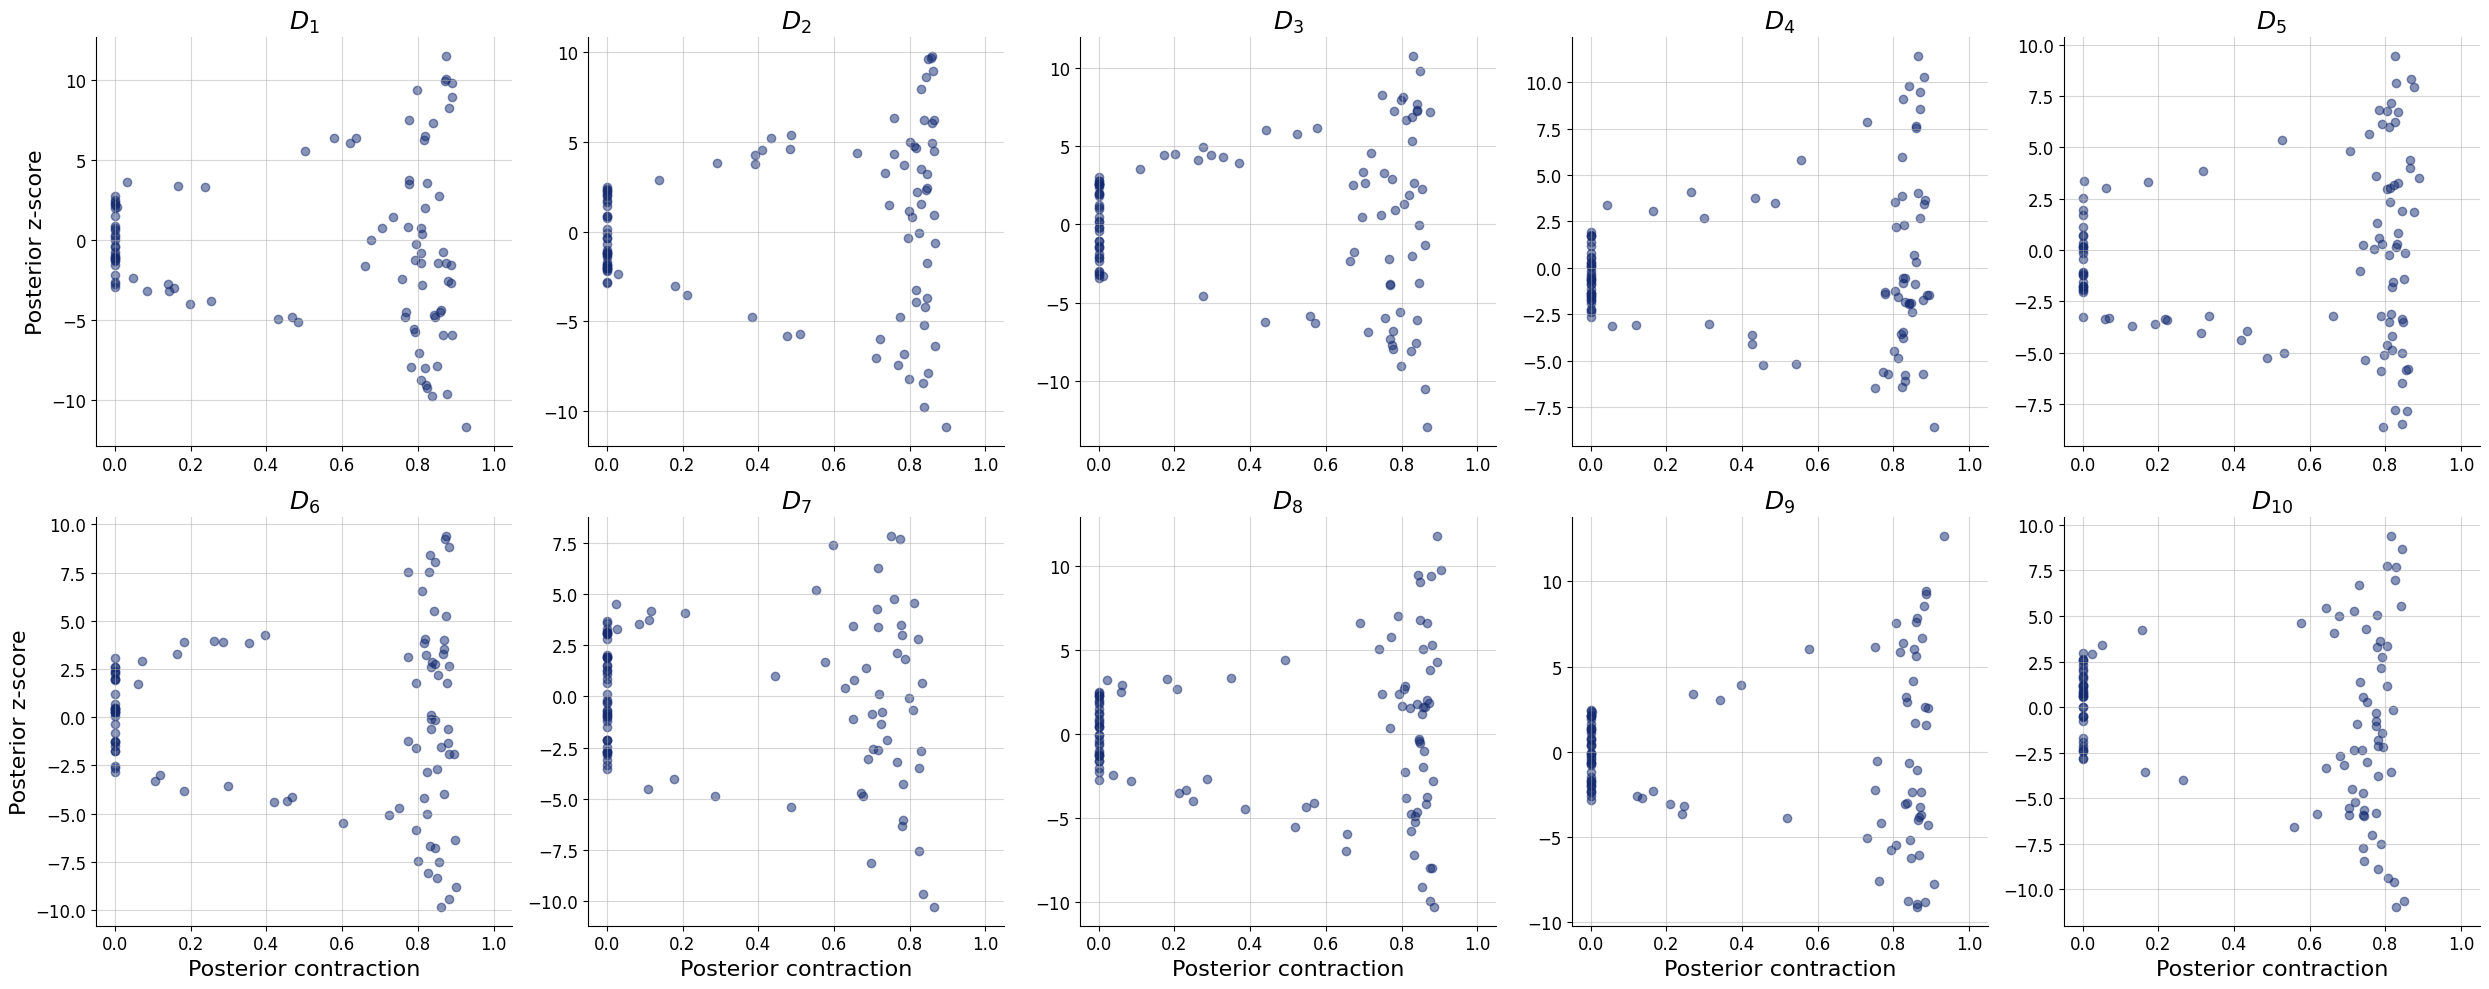

In [19]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.z_score_contraction(posterior_global_samples_valid, np.array(valid_prior_global),
                                            variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/z_score_global_adaptive_sampler{score_model.current_number_of_obs}.png')

diagnostics.calibration_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'].mean()

In [ ]:
posterior_global_samples_valid = probability_ode_solving(score_model, valid_data, obs_n_time_steps=obs_n_time_steps,
                                                         n_post_samples=n_post_samples,
                                                         run_sampling_in_parallel=False,
                                                         device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode{score_model.current_number_of_obs}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode{score_model.current_number_of_obs}.png')

# Step Size for different Grid Sizes

- we compare score model with only one condition, and with $k$-conditions
- we show that the scaling in the number of needed sampling steps only depends on the Bayesian Units used
- error reduces when using more conditions, but since network size stays the same, increases at some point again
- we show how mini batching effects the posterior

Metrics:
- KL divergence between true and estimated posterior samples
- RMSE between the medians of true and estimated posterior samples
- Posterior contraction: (1 - var_empirical_posterior / var_prior) / (1 - var_true_posterior / var_prior), and using the mean variances over all parameters

In [ ]:
# Ensure we generate enough synthetic data samples.
n_samples_data = 100
n_post_samples = 100
score_model.current_number_of_obs = 1
max_steps = 10000
variables_of_interest = ['mini_batch', 'cosine_shift', 'damping_factor_t']

variables_of_interest.append('n_conditions')
variable_of_interest = variables_of_interest[-2]
print(variable_of_interest)

mini_batch = ['10%']
n_conditions = [1]
cosine_shifts = [0]
d_factors = [1]  # using the d factor depending on the mini batch size
data_sizes = np.array([1, 10, 100, 1000, 10000, 100000])

if variable_of_interest == 'mini_batch':
    # Set up your data sizes and mini-batch parameters.
    mini_batch = [1, 10, 100, 1000, 10000, None]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'n_conditions':
    n_conditions = [1, 5, 10, 20, 50, 100]
    second_variable_of_interest = 'data_size'

elif variable_of_interest == 'cosine_shift':
    cosine_shifts = [0, -1, 1, 2, 5, 10]
    second_variable_of_interest = 'data_size'

elif variable_of_interest in ['damping_factor', 'damping_factor_prior', 'damping_factor_t']:
    d_factors = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 0.9, 1]
    second_variable_of_interest = 'data_size'
else:
    raise ValueError('Unknown variable_of_interest')

df_path = f'_plots/{score_model.name}/df_results_{variable_of_interest}.csv'
#df_path = f'results/gaussian_flat/results_{variable_of_interest}.csv'
if os.path.exists(df_path):
    # Load CSV
    df_results = pd.read_csv(df_path, index_col=0)
    # Convert string representations back to lists
    #df_results['list_steps'] = df_results['list_steps'].apply(lambda x: ast.literal_eval(x))

    if variable_of_interest == 'damping_factor_prior':
        df_results['damping_factor_prior'] = df_results['damping_factor']
    elif variable_of_interest == 'damping_factor_t':
        df_results['damping_factor_t'] = df_results['damping_factor']
else:
    df_results = None

In [ ]:
# List to store results.
results = []
reached_max_evals = []

# Iterate over data sizes.
for n in data_sizes:
    # Generate synthetic data with enough samples
    true_params, test_data = generate_synthetic_data(prior, n_samples=n_samples_data, data_size=n,
                                                     normalize=False, random_seed=0)
    true_params = true_params.numpy()
    # Iterate over experimental setting
    for mb, nc, cs, d_factor in itertools.product(mini_batch, n_conditions, cosine_shifts, d_factors):
        # Skip mini-batch settings that are larger than or equal to the data size.
        if mb == '10%':
            mb = max(int(n * 0.1), 1)
        if mb is not None and mb >= n:
            continue
        if nc > n:
            continue

        skip = False
        for max_reached in reached_max_evals:
            if max_reached[0] <= n:  # check if for a smaller data size we already failed
                if max_reached[2] == nc and max_reached[3] == cs and max_reached[4] == d_factor:
                    # all conditions are the same, only mini batch size is different
                    if max_reached[1] is None:
                        pass
                    elif mb is None or max_reached[1] < mb:
                        print(f'smaller mini batch size already failed, skipping {nc}, {cs}')
                        skip = True
                        break
                #elif max_reached[2] == nc and max_reached[3] == cs and max_reached[4] < d_factor:
                #    # all conditions are the same (assuming mini-batching does not change)
                #    # check if smaller damping factor already failed
                #    print(f'smaller damping factor already failed, skipping {nc}, {cs}')
                #    skip = True
                #    break
        if skip:
            results.append({
                "data_size": n,
                "data_id": -1,
                "mini_batch": mb if mb is not None else n,
                "damping_factor": d_factor,
                'n_conditions': nc,
                'cosine_shift': cs,
                "n_steps": max_steps,
                #"list_steps": np.nan,
                "kl": np.nan,
                "median": np.nan,
                "median_rmse": np.nan,
                "c_error": np.nan,
                "contractions": np.nan,
                "rel_contraction": np.nan,
            })
            df_results = pd.DataFrame(results)
            # Convert lists to strings for CSV storage
            #df_results['list_steps'] = df_results['list_steps'].apply(lambda x: str(x))
            df_results.to_csv(df_path)
            continue

        print(f"Data Size: {n}, Mini Batch: {mb}, Conditions: {nc}, Cosine shift: {cs}, Damping Factor: {d_factor}")
        # Set current number of conditions
        score_model.current_number_of_obs = nc

        # Set cosine shit
        score_model.sde.s_shift_cosine = cs

        # Damping factor
        if variable_of_interest == 'damping_factor_t':
            t0_value = 1
            t1_value = d_factor
            damping_factor = lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t)
            if mb is None:
                mini_batch_arg = {'damping_factor': damping_factor}
            else:
                mini_batch_arg = {'size': mb, 'damping_factor': damping_factor}
        elif variable_of_interest == 'damping_factor_prior':
            damping_factor = lambda t: torch.ones_like(t) * d_factor
            if mb is None:
                mini_batch_arg = {'damping_factor_prior': damping_factor}
            else:
                mini_batch_arg = {'size': mb, 'damping_factor_prior': damping_factor}
        else:
            damping_factor = lambda t: torch.ones_like(t) * d_factor
            if mb is None:
                mini_batch_arg = {'damping_factor': damping_factor, 'damping_factor_prior': 1}
            else:
                mini_batch_arg = {'size': mb, 'damping_factor': damping_factor, 'damping_factor_prior': 1}

        # Run adaptive sampling.
        print(mini_batch_arg)
        try:
            test_samples, list_steps = adaptive_sampling(score_model, test_data, conditions=None,
                                                         obs_n_time_steps=obs_n_time_steps,
                                                         n_post_samples=n_post_samples,
                                                         mini_batch_arg=mini_batch_arg,
                                                         max_evals=max_steps*2,
                                                         t_end=0, random_seed=0, device=torch_device,
                                                         run_sampling_in_parallel=False,  # can actually be faster
                                                         return_steps=True)
        except torch.OutOfMemoryError as e:
            print(e)
            results.append({
                "data_size": n,
                "data_id": -1,
                "mini_batch": mb if mb is not None else n,
                "damping_factor": d_factor,
                'n_conditions': nc,
                'cosine_shift': cs,
                "n_steps": max_steps,
                #"list_steps": np.nan,
                "kl": np.nan,
                "median": np.nan,
                "median_rmse": np.nan,
                "c_error": np.nan,
                "contractions": np.nan,
                "rel_contraction": np.nan,
            })
            df_results = pd.DataFrame(results)
            # Convert lists to strings for CSV storage
            #df_results['list_steps'] = df_results['list_steps'].apply(lambda x: str(x))
            df_results.to_csv(df_path)
            continue

        # Sample the true posterior.
        true_samples = np.stack([sample_posterior(x, prior_sigma=prior.scale,
                                                  sigma=prior.simulator.scale, n_samples=n_post_samples) for x in test_data], axis=0)

        # Compute metrics.
        if test_samples.shape[1] > 1:
            kl = [kl_divergence(test_data[i], test_samples[i], prior=prior) for i in range(n_samples_data)]
        else:
            kl = [np.nan for i in range(n_samples_data)]

        rmse = diagnostics.root_mean_squared_error(test_samples, true_params)['values'].mean()
        c_error = diagnostics.calibration_error(test_samples, true_params)['values'].mean()

        contractions = diagnostics.posterior_contraction(test_samples, true_params)['values'].mean()
        true_contraction = posterior_contraction(prior_std=prior.scale, likelihood_std=prior.simulator.scale, n_obs=n).mean()
        rel_contraction = (contractions / true_contraction)

        # Number of steps
        if np.isnan(test_samples).any():
            n_steps = np.inf
            reached_max_evals.append((n, mb, nc, cs, d_factor))
        else:
            n_steps = np.mean([len(ls) for ls in list_steps])
            if n_steps >= max_steps:
                # others will also fail to converge
                reached_max_evals.append((n, mb, nc, cs, d_factor))

        # Print current metrics.
        print(f"KL: {np.mean(kl)}, #Steps: {n_steps}")

        # Save results into a dictionary.
        for i in range(n_samples_data):  # might be less than the actual data points because inference failed
            results.append({
                "data_size": n,
                "data_id": i,
                "mini_batch": mb if mb is not None else n,
                "damping_factor": d_factor,
                'n_conditions': nc,
                'cosine_shift': cs,
                "n_steps": n_steps,
                #"list_steps": np.where(np.isnan(list_steps[0]), None, list_steps[0]).tolist(),  # only for the first sample
                "kl": kl[i],
                "median": np.median(test_samples, axis=1)[i],
                "median_rmse": rmse,
                "c_error": c_error,
                "contractions": contractions,
                "rel_contraction": rel_contraction
            })

        # Create a DataFrame from the results list. Save intermediate results
        df_results = pd.DataFrame(results)
        # Convert lists to strings for CSV storage
        #df_results['list_steps'] = df_results['list_steps'].apply(lambda x: str(x))
        df_results.to_csv(df_path)

# Convert string representations back to lists
#df_results['list_steps'] = df_results['list_steps'].apply(lambda x: ast.literal_eval(x))

In [ ]:
colors = ['#a6cee3', '#1f77b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']

metrics = {
    'kl': 'KL Divergence',
    'median_rmse': 'RMSE',
    'rel_contraction': 'Relative Posterior Contraction',
    'c_error': 'Calibration Error'
}

experiment_names = {
    'damping_factor': 'Damping Factor',
    'damping_factor_t': 'Damping Factor\nTime Dependent',
    'damping_factor_prior': 'Damping Factor Prior',
    'n_conditions': 'Number of Conditions',
    'cosine_shift': 'Cosine Shift',
    'data_size': 'Data Size',
    'mini_batch': 'Mini Batch Size'
}

In [ ]:
# Group by both second_variable_of_interest and variable_of_interest to compute mean and standard deviation of n_steps.
grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(['mean','std']).reset_index()

# Determine unique second_variable_of_interest and variable_of_interest values.
second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

# Set up errorbar plot parameters.
n_groups = len(second_variable_of_interest_values)
n_series = len(variable_batch_values)
x = np.arange(n_groups)  # base x locations for groups

fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
# Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
for i, mb in enumerate(variable_batch_values):
    subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
    means = []
    stds = []
    for ds in second_variable_of_interest_values:
        row = subset[subset[second_variable_of_interest] == ds]
        if not row.empty:
            means.append(row['mean'].values[0])
            stds.append(row['std'].values[0])
        else:
            means.append(np.nan)
            stds.append(0)

    # Use 'o-' for markers connected by lines.
    ax.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])

ax.axhline(max_steps, color='k', linestyle='--')
ax.text(0.1, max_steps-3500, f"Maximal Number of Steps", fontsize=8, color='k')

# Center the x-axis ticks and label them.
ax.set_xticks(x)
ax.set_xticklabels(second_variable_of_interest_values)
ax.set_xlabel(experiment_names[second_variable_of_interest])
ax.set_ylabel('Number of Steps')
#ax.set_title(f'Number of Steps by {experiment_names[second_variable_of_interest]} and {experiment_names[variable_of_interest]}')
ax.set_yscale('log')
ax.legend(title=experiment_names[variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_n_steps.png', bbox_inches='tight')
plt.show()

In [ ]:
if variable_batch_values == 'mini_batch_size':
    # ------------------------------
    # Plot 1: Bar plot of n_steps for the full-batch  case.
    # ------------------------------

    # Filter the full-batch rows
    df_full = df_results[df_results['data_size'] == df_results['mini_batch']]

    # Group by data_size and compute mean and standard deviation of n_steps.
    grouped_full = df_full.groupby('data_size')['n_steps'].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(4, 3), tight_layout=True)
    plt.bar(grouped_full['data_size'], grouped_full['mean'],
            yerr=grouped_full['std'], capsize=5, color='skyblue', edgecolor='black')
    plt.xlabel('Data Size')
    plt.ylabel('Number of Steps')
    plt.title('Number of Steps (Full Batch) per Data Size')
    plt.xticks(grouped_full['data_size'])
    plt.yscale('log')
    plt.xscale('log')
    plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_steps_full_batch.png', bbox_inches='tight')
    plt.show()

# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. variable_of_interest.
# ------------------------------

# Filter rows with a variable_of_interest value (skip full-batch rows).
df_mb = df_results[df_results[variable_of_interest].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb[variable_of_interest] = df_mb[variable_of_interest].astype(float)

# Define the metrics to plot: key is dataframe column, value is label for y-axis.
y_limits = {
    #'kl': (0, 100),
    'median_rmse': (-0.1, 1),
    'rel_contraction': (-0.1, 1.2),
    'c_error': (-0.05, 0.55)
}

# Identify the unique data sizes (to plot different lines per data size).
unique_second_variable_of_interest = sorted(df_mb[second_variable_of_interest].unique())

# Create one figure per metric.
for metric, metric_label in metrics.items():
    plt.figure(figsize=(5, 3), tight_layout=True)
    for i, ds in enumerate(unique_second_variable_of_interest):
        # Select the rows for this particular data size.
        df_sub = df_mb[(df_mb[second_variable_of_interest] == ds) & (df_mb['n_steps'] != max_steps)]
        # Group by variable_of_interest size to get mean and std of the metric.
        grouped = df_sub.groupby(variable_of_interest)[metric].agg(['mean', 'std']).reset_index()
        if not np.isfinite(grouped['mean']).all() or grouped.empty:
            continue
        plt.errorbar(grouped[variable_of_interest], grouped['mean'], yerr=grouped['std'],
                     marker='o', capsize=5, label=f'{ds}', alpha=0.75, color=colors[i])
    plt.xlabel(experiment_names[variable_of_interest])
    plt.ylabel(metric_label)
    #plt.title(f'{metric_label} vs {experiment_names[variable_of_interest]}')
    plt.legend(title=experiment_names[second_variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    if metric == 'rel_contraction':
        plt.axhline(1, linestyle='--', color='k')
        if variable_of_interest == 'mini_batch':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'n_conditions':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'cosine_shift':
            plt.text(1, 1.05, f"Optimal", fontsize=8, color='k')
        elif variable_of_interest == 'damping_factor_t':
            plt.text(0.1, 1.05, f"Optimal", fontsize=8, color='k')

    if variable_of_interest == 'mini_batch':
        plt.xscale('log')
    if metric == 'kl':
        plt.yscale('log')
    else:
        plt.ylim(y_limits[metric])
    plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_{metric}.png', bbox_inches='tight')
    plt.show()

## Number of Steps

In [ ]:
variable_of_interest = 'mini_batch'
df_path = f'results/gaussian_flat/results_{variable_of_interest}.csv'
if os.path.exists(df_path):
    # Load CSV
    df_results_mini = pd.read_csv(df_path, index_col=0)
    # Convert string representations back to lists
    #df_results_mini['list_steps'] = df_results_mini['list_steps'].apply(lambda x: ast.literal_eval(x))

    if variable_of_interest == 'damping_factor_prior':
        df_results_mini['damping_factor_prior'] = df_results_mini['damping_factor']
    elif variable_of_interest == 'damping_factor_t':
        df_results_mini['damping_factor_t'] = df_results_mini['damping_factor']
else:
    df_results_mini = None

variable_of_interest = 'n_conditions'
df_path2 = f'results/gaussian_flat/results_{variable_of_interest}.csv'
if os.path.exists(df_path2):
    # Load CSV
    df_results_cond = pd.read_csv(df_path2, index_col=0)
    # Convert string representations back to lists
    #df_results_cond['list_steps'] = df_results_cond['list_steps'].apply(lambda x: ast.literal_eval(x))

    if variable_of_interest == 'damping_factor_prior':
        df_results_cond['damping_factor_prior'] = df_results_cond['damping_factor']
    elif variable_of_interest == 'damping_factor_t':
        df_results_cond['damping_factor_t'] = df_results_cond['damping_factor']
else:
    df_results_cond = None

In [ ]:
df_dictionary = pd.DataFrame([
    {'data_size': 100000, 'mini_batch': 10, 'n_steps': max_steps},
    {'data_size': 100000, 'mini_batch': 100, 'n_steps': max_steps},
    {'data_size': 100000, 'mini_batch': 1000, 'n_steps': max_steps},
    {'data_size': 10000, 'mini_batch': 10, 'n_steps': max_steps},
    {'data_size': 10000, 'mini_batch': 100, 'n_steps': max_steps},
    {'data_size': 100000, 'mini_batch': 1000, 'n_steps': max_steps}
])
df_results = pd.concat([df_results_mini, df_dictionary], ignore_index=True)

In [ ]:
n_steps_raw = df_results_mini[['n_steps', 'data_size']].groupby('data_size').agg(['mean', 'std'])
n_steps_raw

In [ ]:
fig, axis = plt.subplots(ncols=2, figsize=(10, 3), sharex=True, sharey=True, tight_layout=True)

second_variable_of_interest = 'data_size'
axis[0].errorbar(n_steps_raw.index, n_steps_raw.n_steps.values[:, 0], yerr=n_steps_raw.n_steps.values[:, 1],
                 fmt='o-', capsize=5, alpha=0.75, color=colors[0])

for df_results, ax, variable_of_interest in zip([df_results_cond],
                                                [axis[-1]],
                                                ['n_conditions']):

    # Group by both second_variable_of_interest and variable_of_interest to compute mean and standard deviation of n_steps.
    grouped_bar = df_results.groupby([second_variable_of_interest, variable_of_interest])['n_steps'].agg(['mean','std']).reset_index()

    # Determine unique second_variable_of_interest and variable_of_interest values.
    second_variable_of_interest_values = sorted(grouped_bar[second_variable_of_interest].unique())
    variable_batch_values = sorted(grouped_bar[variable_of_interest].unique())

    # Set up errorbar plot parameters.
    n_groups = len(second_variable_of_interest_values)
    n_series = len(variable_batch_values)
    x = np.arange(n_groups)  # base x locations for groups

    # Plot an errorbar for each variable_of_interest value within each second_variable_of_interest group.
    for i, mb in enumerate(variable_batch_values):
        subset = grouped_bar[grouped_bar[variable_of_interest] == mb]
        means = []
        stds = []
        for ds in second_variable_of_interest_values:
            row = subset[subset[second_variable_of_interest] == ds]
            if not row.empty:
                means.append(row['mean'].values[0])
                stds.append(row['std'].values[0])
            else:
                means.append(np.nan)
                stds.append(0)

        means = np.array(means)
        means[means > max_steps] = max_steps

        # Center the x-axis ticks and label them.
        if variable_of_interest == 'n_conditions':
            ax.errorbar(second_variable_of_interest_values / mb, means,
                        yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
            #if i == 0:
            #    axis[0].errorbar(second_variable_of_interest_values / mb, means,
            #            yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])
        else:
            # Use 'o-' for markers connected by lines.
            ax.errorbar(second_variable_of_interest_values, means, yerr=stds, fmt='o-', capsize=5, label=f'{mb}', alpha=0.75, color=colors[i])

    ax.legend(title=experiment_names[variable_of_interest], loc='upper left', bbox_to_anchor=(1, 1))

for ax in axis:
    ax.axhline(max_steps, color='k', linestyle='--')
    ax.text(1, max_steps-3500, f"Maximal Number of Steps", fontsize=8, color='k')
    ax.set_xticks(second_variable_of_interest_values)
    ax.set_xticklabels(second_variable_of_interest_values)
    ax.set_xlabel('Information Units')
    ax.set_ylabel('Number of Steps')
    #ax.set_title(f'Number of Steps by {experiment_names[second_variable_of_interest]} and {experiment_names[variable_of_interest]}')
    ax.set_yscale('log')
    ax.set_xscale('log')


plt.savefig(f'plots/{score_model.name}/{variable_of_interest}_n_steps_conditions.png', bbox_inches='tight')
plt.show()